In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer
from qiskit import Aer
from qiskit import execute
import numpy as np
%matplotlib inline

In this notebook, we use Qiskit to develop a circuit that implements a quantum Fourier transform. Recall that the quantum Fourier transform (or, depending on conventions, its inverse) is given by
$$
|x \rangle \mapsto \frac{1}{\sqrt{2^n}} \sum_s \eta^{xs} |s \rangle
$$
where $\eta$ is an $2^n$-th root of unity with n being the number of qubits in the register, i.e.
$$
\eta = \exp \frac{2\pi i}{2^n}
$$

How can we efficiently calculate the quantum Fourier transform? The standard approach (which is explained in all standard textbooks) is as follows. First, we observe that the state above is in fact a product state. In fact, we can make the decomposition
$$
\sum_s \eta^{xs} |s \rangle = (|0\rangle + \eta^{2^{n-1} x}|1\rangle)(|0 \rangle + \eta^{2^{n-2}x}|1 \rangle) \cdots (|0 \rangle + \eta^x|1 \rangle)
$$
Thus the most significant qubit (q[n-1] in the OpenQASM convention is given by
$$
(|0 \rangle + \eta^{2^{n-1}x} |1 \rangle
$$
Let us analyse this further. For that purpose, we decompose the integer x into its binary representation, i.e. we write
$$
x = \sum_{i=0}^{n-1} 2^i x_i
$$
Then
$$
2^{n-1} x = \sum_{i=0}^{n-1} 2^{n-1+i} x_i = 2^{n-1} x_0 + 2^n \sum_{i=1}^{n-1} 2^{i-1} x_i
$$
Now the second term is a multiple of $2^n$, and therefore
$$
\eta^{2^{n-1}x} = \eta^{2^{n-1} x_0} = \exp (i \pi x_0)
$$
Thus the most significant bit is
$$
|0 \rangle + e^{i \pi x_0} |1 \rangle
$$
But since $e^{i\pi} = -1$, this is simply
$$
H |x_0 \rangle
$$
What about the second qubit q[n-2]? We have
$$
2^{n-2} x = \sum_{i=0}^{n-1} 2^{n-2+i} x_i = 2^{n-2} x_0 + 2^{n-1} x_1 + 2^n \sum_{i=2}^{n-1} 2^{i-2} x_i
$$
and therefore
$$
\eta^{2^{n-2}x} = \eta^{2^{n-2}x_0} \cdot \eta^{2^{n-1}x_1}
$$
Thus the second qubit is
$$
|0 \rangle + \eta^{2^{n-2}x_0} \cdot \eta^{2^{n-1}x_1} |1 \rangle
$$
On the other hand, 
$$
H |x_1 \rangle = |0 \rangle + e^{i \pi x_1} |1 \rangle = |0 \rangle + \eta^{2^{n-1}x_1} |1 \rangle
$$
Thus the second qubit is obtained from $|x_1 \rangle$ by first applying the Hadamard gate and then applying a conditional rotation 
$$
\begin{pmatrix} 1 & 0 \\ 0 & e^{i \frac{\pi}{2}} \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix} = S
$$
around the z-axis, conditioned on $x_0$. Similarly, the third qubit is obtained by first applying a Hadamard to $|x_2\rangle$, followed by a conditional rotation as above conditioned on $x_1$, followed by a conditional rotation 
$$
\begin{pmatrix} 1 & 0 \\ 0 & e^{i \frac{\pi}{4}} \end{pmatrix}
$$
conditioned on $x_0$. 


We now see a clear pattern evolving. Let us try to write this down formally. For general j, we have
$$
2^{n-j} x = \sum_{j=0}^{n-1} 2^{n-j} x_i = \sum_{i<j}  2^{n-j+i} x_i + 2^n \sum_{i=j}^{n-1} 2^{i-j} x_i
$$
and therefore qubit n - j is 
$$
|0 \rangle + \prod_{i < j - 1} \eta^{2^{n-j+i}x_i} H |x_{j-1}\rangle
$$
which is again a Hadamard gate followed by a product of conditional rotations around the z-axis. This is encoded into a circuit as follows.

In [2]:
def nBitQFT(q,c,n=3):
    circuit = QuantumCircuit(q,c)
    #
    # We start with the most significant bit
    #
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        circuit.h(q[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),q[i], q[j-1])
    #
    # Finally we need to swap qubits
    #
    for i in range(n//2):
        circuit.swap(q[i], q[n-i-1])
    return circuit

Let us now test this. For that purpose, we first express the action of the quantum Fourier transform on the standard basis as a unitary matrix.

In [3]:
def qftMatrix(n):
    qft = np.zeros([2**n,2**n], dtype=complex)
    for i in range(2**n):
        for j in range(2**n):
            qft[i,j] = np.exp(i*j*2*1j*np.pi/(2**n))
    return 1/np.sqrt(2**n)*qft

Now we can test our circuit. We use the unitary simulator that returns the unitary matrix implemented by our circuit and compare the outcome to the expected unitary matrix.

In [4]:
#
# Test the circuit for n bits
# 
def testCircuit(n):
    q = QuantumRegister(n,"x")
    c = ClassicalRegister(n,"c")
    circuit = nBitQFT(q,c,n)

    backend = Aer.get_backend('unitary_simulator') 
    job = execute(circuit, backend)
    actual = job.result().get_unitary()
    np.around(actual,2)
    expected = qftMatrix(n)
    delta = actual - expected
    print("Deviation: ", round(np.linalg.norm(delta),10))
    return circuit

Deviation:  0.0


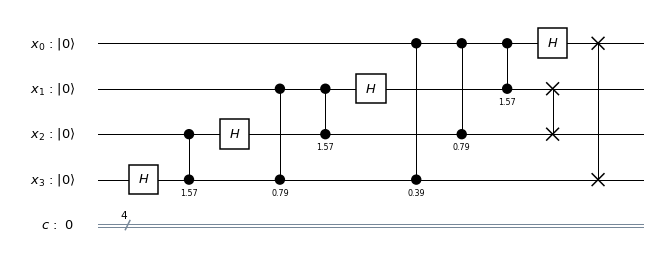

In [5]:
circuit = testCircuit(n=4)
my_style = {'cregbundle': True}
drawer(circuit, style=my_style)

Let us now apply our circuit to an example input. Obviously, the state $|0\rangle$ maps to a state which is an equal superposition of all states. Conversely, we expect that if we apply the Fourier transform to this state, we get $|0\rangle$ back. Let us do this.

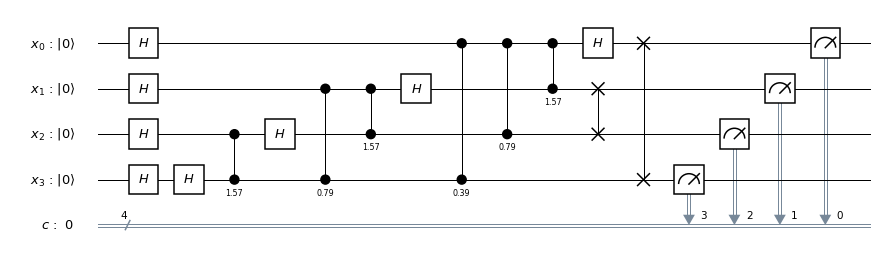

In [6]:
n=4
q = QuantumRegister(n,"x")
c = ClassicalRegister(n,"c")
qftCircuit = nBitQFT(q,c,n)
initCircuit = QuantumCircuit(q,c)
for i in range(n):
    initCircuit.h(q[i])
initCircuit.barrier(q)
circuit = initCircuit + qftCircuit
circuit.barrier(q)
circuit.measure(q,c)
drawer(circuit, style=my_style)

In [7]:
backend = Aer.get_backend('qasm_simulator') 
job = execute(circuit, backend)
job.result().get_counts()

{'0000': 1024}

As always, we finally test this on real hardware.

In [8]:
from qiskit import IBMQ
IBMQ.load_accounts()
backend = IBMQ.get_backend('ibmq_16_melbourne') 
print("Status of backend: ", backend.status())
from qiskit import compile
qobj = compile(circuit, backend=backend, shots=1024)

Status of backend:  {'pending_jobs': 1, 'name': 'ibmq_16_melbourne', 'operational': True}


In [9]:
#
# Submit as a job and wait for completion
#
job = backend.run(qobj)
import time
lapse = 0
#
# Wait three seconds once, this should be good enough for the simulator in most cases
#
time.sleep(3)
interval = 60
while (job.status().name != 'DONE') and (job.status().name != 'CANCELLED') and (job.status().name != 'ERROR'):
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    print(job.queue_position())
    time.sleep(interval)
    lapse += 1
print(job.status())

Status @ 0 seconds
JobStatus.QUEUED
2
Status @ 60 seconds
JobStatus.QUEUED
1
Status @ 120 seconds
JobStatus.QUEUED
1
JobStatus.DONE


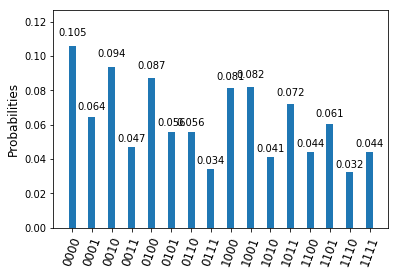

In [10]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(job.result().get_counts())

In [11]:
job.result().get_counts()

{'0000': 108,
 '0001': 66,
 '0010': 96,
 '0011': 48,
 '0100': 89,
 '0101': 57,
 '0110': 57,
 '0111': 35,
 '1000': 83,
 '1001': 84,
 '1010': 42,
 '1011': 74,
 '1100': 45,
 '1101': 62,
 '1110': 33,
 '1111': 45}

We clearly see that we have reached a level of noise that significantly distorts our result. This is not really surprising given the number of gates - if we dump the compiled QASM code, we find that our circuit contains roughly 140 gates.

In [12]:
compiled_qasm = qobj.as_dict()['experiments'][0]['header']['compiled_circuit_qasm']
print("Compiled qasm:\n", compiled_qasm)

Compiled qasm:
 OPENQASM 2.0;
include "qelib1.inc";
qreg q[14];
creg c[4];
u2(0,3.14159265358979) q[13];
u2(0,3.14159265358979) q[2];
u2(0,3.14159265358979) q[1];
u2(0,3.14159265358979) q[0];
barrier q[0],q[1],q[2],q[13];
u2(0,3.14159265358979) q[13];
u2(0,3.92699081698724) q[2];
u1(0.392699081698724) q[1];
u2(0,3.33794219443916) q[0];
cx q[13],q[1];
u2(0,3.14159265358979) q[1];
u2(0,3.14159265358979) q[13];
cx q[13],q[1];
u2(0,3.14159265358979) q[1];
u2(0,3.14159265358979) q[13];
cx q[13],q[1];
u2(0,3.14159265358979) q[1];
cx q[1],q[2];
u3(0.785398163397448,1.57079632679490,4.71238898038469) q[1];
cx q[1],q[2];
u2(0.785398163397448,3.14159265358979) q[1];
cx q[13],q[1];
u1(-0.392699081698724) q[1];
cx q[13],q[1];
u1(0.785398163397448) q[13];
u1(0.392699081698724) q[1];
cx q[13],q[1];
u2(0,3.14159265358979) q[1];
u2(0,3.14159265358979) q[13];
cx q[13],q[1];
u2(0,3.14159265358979) q[1];
u2(0,3.14159265358979) q[13];
cx q[13],q[1];
cx q[1],q[2];
u1(-0.785398163397448) q[2];
cx q[13],q[1]

Of course, we could now start to simplify our circuit. In this particular case, we could remove the final swaps, as we are performing a measurement anyway. We could also eliminate Hadamard gates that cancel each other to reduce the overall number of gates and we could try to rearrange qubits to deal with the coupling map of the specific IBM model. However, this example shows that even comparatively small circuits are probing the limits of the currently available hardware. Let us see whether the situation is much better with n=3.

In [13]:
n=3
q = QuantumRegister(n,"x")
c = ClassicalRegister(n,"c")
qftCircuit = nBitQFT(q,c,n)
initCircuit = QuantumCircuit(q,c)
for i in range(n):
    initCircuit.h(q[i])
initCircuit.barrier(q)
circuit = initCircuit + qftCircuit
circuit.barrier(q)
circuit.measure(q,c)
qobj = compile(circuit, backend=backend, shots=1024)

In [14]:
#
# Submit as a job and wait for completion
#
job = backend.run(qobj)
import time
lapse = 0
#
# Wait three seconds once, this should be good enough for the simulator in most cases
#
time.sleep(3)
interval = 60
while (job.status().name != 'DONE') and (job.status().name != 'CANCELLED') and (job.status().name != 'ERROR'):
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    print(job.queue_position())
    time.sleep(interval)
    lapse += 1
print(job.status())

Status @ 0 seconds
JobStatus.RUNNING
0
JobStatus.DONE


In [15]:
job.result().get_counts()

{'000': 512,
 '001': 133,
 '010': 22,
 '011': 15,
 '100': 217,
 '101': 99,
 '110': 14,
 '111': 12}

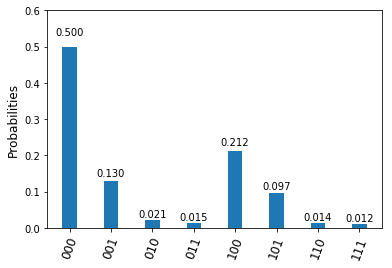

In [16]:
plot_histogram(job.result().get_counts())